# Тестовое задание

### Описание данных

В приложении к заданию есть файл database.db. Он представляет собой файл БД на фреймворке sqlite3. Синтаксис SQL, используемый в данной БД почти не отличается от ORACLE DB (более подробно можно почитать тут: https://unetway.com/tutorial/sqlite-syntax).
Запросы к базе можно сохранять сразу в pandas.Dataframe, используя следующий код:

In [ ]:
import pandas as pd
import sqlite3 as sql
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
# Загрузка файла из GitHub
!wget https://raw.githubusercontent.com/ADMukhametzianov/VTB/main/database.db

In [2]:
query = 'SELECT * FROM pl limit 5'
con = sql.connect('database.db')
df = pd.read_sql_query(sql = query, con=con)
con.close()

df

,client_id,segment,period,product,pl
0,ZDosW1zUAi,Массовый,p_1,Кредит,9.018067
1,wVRHQ9hzrw,Массовый,p_1,Кредит,18.889585
2,6DZQIaOyL3,Массовый,p_1,Кредит,0.369257
3,jDwO0sMhL2,Массовый,p_1,Кредит,124.315319
4,FXIJUkgjLy,Массовый,p_1,Кредит,41.287831


   В базе данных хранится 2 таблицы: pl и campaign. Ключами для связи этих таблиц является поле client_id. В таблице pl находится информация о ЧОД (чистый операционный доход) от клиента с продуктом в разрезе периодов. В таблице campaign хранятся данные о прошедшей  между отчетными периодами "p_1" и "p_2" маркетинговой кампании.<br>
Атрибутный состав таблицы pl:
   - client_id - id клиента
   - segment - сегмент клиента внутри СМБ(Средний и малый бизнес)
   - period - период расчета ЧОД банка от продукта, используемого клиентом
   - product - продукт
   - pl - ЧОД в тысячах рублей
   
Пример: строка 0 на срезе выше - в периоде "p_1" за продукт "Кредит" с клиента "yxwtZv530y" массового сегмента банк заработал 0.374924 тыс. рублей.
   
Если в каком-либо периоде информация о клиенте/продукте у клиента отсутствует, значит в этот период клиента в банке не было/клиент продуктом не пользовался.

Атрибутный состав таблицы campaign:
- client_id - id клиента
- product - продукт кампании
- response - статус отклика на предложение
- manager_id - id менеджера, на которого назначен клиент

### Задание

1) Посчитать средний ЧОД по продуктам и количество клиентов с продуктом для каждого сегмента в разрезе периодов.<br>
2) Посчитать средний ЧОД и количество клиентов в каждом сегменте в разрезе периодов.<br>
3) Оценить отток клиентов с продуктов в периоде p_2.<br>
4) Посчитать сумму ЧОД, привлеченную каждым менеджером в ходе маркетинговой кампании<br>
5) Оценить эффективность маркетинговой кампании.

### Задание 1. Посчитать средний ЧОД по продуктам и количество клиентов с продуктом для каждого сегмента в разрезе периодов.<br>

In [16]:
con = sql.connect('database.db')

query_pl = "SELECT * FROM pl"
df_pl = pd.read_sql_query(query_pl, con)

result = df_pl.groupby(['segment', 'period', 'product']).agg({'pl': 'mean', 'client_id': pd.Series.nunique}).reset_index()
result.pl = round(result.pl, 1)

print(result)

con.close()

        segment period           product     pl  client_id
0       Верхний    p_1  Банковская карта   60.6         49
1       Верхний    p_1           Депозит  112.5        254
2       Верхний    p_1            Кредит  236.9        360
3       Верхний    p_1               РКО   22.8       1149
4       Верхний    p_1         Эквайринг   80.5        183
5       Верхний    p_2  Банковская карта   51.8        167
6       Верхний    p_2           Депозит   99.3        283
7       Верхний    p_2            Кредит  248.2        548
8       Верхний    p_2               РКО   22.1       1162
9       Верхний    p_2         Эквайринг   73.0        284
10     Массовый    p_1  Банковская карта   13.3        895
11     Массовый    p_1           Депозит   28.7       3537
12     Массовый    p_1            Кредит   59.2       5247
13     Массовый    p_1               РКО    5.8      16728
14     Массовый    p_1         Эквайринг   19.6       2625
15     Массовый    p_2  Банковская карта   11.7       26

### Задание 2. Посчитать средний ЧОД и количество клиентов в каждом сегменте в разрезе периодов.<br>

In [5]:
con = sql.connect('database.db')

query = """
SELECT
    pl.segment,
    pl.period,
    round(AVG(pl.pl), 1) AS avg_pl,
    COUNT(DISTINCT pl.client_id) AS client_count
FROM pl
LEFT JOIN campaign ON pl.client_id = campaign.client_id
GROUP BY pl.segment, pl.period
ORDER BY pl.segment, pl.period;
"""

result = pd.read_sql_query(query, con)

print(result)

con.close()

       segment period  avg_pl  client_count
0      Верхний    p_1    79.1          1195
1      Верхний    p_2    89.7          1206
2     Массовый    p_1    19.7         17207
3     Массовый    p_2    23.3         17330
4  Стандартный    p_1    40.3          6061
5  Стандартный    p_2    46.5          6110


### Задание 3. Оценить отток клиентов с продуктов в периоде p_2.<br>

In [6]:
con = sql.connect('database.db')

query = """
SELECT
    pl.product,
    COUNT(DISTINCT CASE WHEN pl.period = 'p_1' THEN pl.client_id END) AS p1_clients,
    COUNT(DISTINCT CASE WHEN pl.period = 'p_2' THEN pl.client_id END) AS p2_clients,
    COUNT(DISTINCT CASE WHEN pl.period = 'p_2' THEN pl.client_id END) - COUNT(DISTINCT CASE WHEN pl.period = 'p_1' THEN pl.client_id END) AS client_diff
FROM pl
GROUP BY pl.product
"""

result = pd.read_sql_query(query, con)
result["client_diff_percent"] = round(result.client_diff/result.p1_clients*100, 2)

print(result)

con.close()

            product  p1_clients  p2_clients  client_diff  client_diff_percent
0  Банковская карта        1282        3720         2438               190.17
1           Депозит        5083        6198         1115                21.94
2            Кредит        7478       11264         3786                50.63
3               РКО       23784       23732          -52                -0.22
4         Эквайринг        3770        6298         2528                67.06


##### По всем продуктам, кроме РКО, приток клиентов составил от 21% до 190% в периоде p_2 по отношению к периоду p_1. Но это произошло не засчет новых клиентов, а засчет того, что клиенты расширили линейки продуктов, которыми они пользовались. По РКО количество клиентов практически не изменилось.

### Задание 4. Посчитать сумму ЧОД, привлеченную каждым менеджером в ходе маркетинговой кампании<br>

In [51]:
con = sql.connect('database.db')

query = """
SELECT
    c.manager_id,
    round(SUM(CASE WHEN p.period = 'p_2' THEN p.pl ELSE 0 END)) -
    round(SUM(CASE WHEN p.period = 'p_1' THEN p.pl ELSE 0 END)) AS income
FROM campaign c
JOIN pl p ON c.client_id = p.client_id
GROUP BY c.manager_id
"""

result = pd.read_sql_query(sql=query, con=con)

con.close()
print(result)
print("Среднее значение ЧОД:", result.income.mean())

       manager_id   income
0   CM_2755B4KTu4  23029.0
1   CM_6ofody41cY  19562.0
2   CM_70HjN0EVqf  19128.0
3   CM_9vMKq9aqw9  18429.0
4   CM_EiBeeRMhdA  19156.0
5   CM_PzEEav4ic0  18421.0
6   CM_R7BdTh0Svt  19397.0
7   CM_RCwv1r0OHO  19028.0
8   CM_c28lGRRaEI  21017.0
9   CM_dcTdLjqH2x  16675.0
10  CM_doxY9cvELI  20008.0
11  CM_eE0WMK1vVW  19262.0
12  CM_fQHTUUUkXc  19194.0
13  CM_gHP4ykbzTj  20519.0
14  CM_lKxhD73Z6d  19225.0
15  CM_nJ7j5pAcMB  15344.0
16  CM_onY6ha8qHv  18608.0
17  CM_pMFgOhtUKD  21577.0
18  CM_wjb2ArrpAw  20270.0
19  CM_zShYeVNFi0  19218.0
Среднее значение ЧОД: 19353.35


5. Оценить эффективность маркетинговой кампании.

In [38]:
con = sql.connect('database.db')

query1 = """
SELECT
    COUNT(DISTINCT product) AS products_p1
FROM pl
WHERE period = 'p_1'
GROUP BY client_id
"""
query2 = """
SELECT
    COUNT(DISTINCT product) AS products_p2
FROM pl
WHERE period = 'p_2'
GROUP BY client_id
"""
df1 = pd.read_sql_query(query1, con)
df2 = pd.read_sql_query(query2, con)
print("Среднее количество продуктов на клиента на период p_1:", round(df1.products_p1.mean(), 2))
print("Среднее количество продуктов на клиента на период p_2:", round(df2.products_p2.mean(), 2))

t_statistic, p_value = ttest_ind(df1.products_p1, df2.products_p2)

alpha = 0.05 # Уровень значимости
if p_value < alpha:
    print("Различия между средними значениями статистически значимы")
else:
    print("Различия между средними значениями не являются статистически значимыми")

print(f"Значение t-статистики: {t_statistic:.4f}")
print(f"p-значение: {p_value:.4f}")
con.close()

Среднее количество продуктов на клиента на период p_1: 1.69
Среднее количество продуктов на клиента на период p_2: 2.08
Различия между средними значениями статистически значимы
Значение t-статистики: -52.9193
p-значение: 0.0000


### **Вывод**: маркетинговая кампания прошла успешно, так как:


*   среднее кол-во продуктов на одного клиента с периода p_1 по период p_2 увеличилось с 1,69 до 2,08. Различие этих средних значимо, что подтверждается t-тестом.
*   среднее значение ЧОД привлеченное каждым менеджером в течение кампании составляет 19.353 тыс.

 На гистограмме ниже можно увидеть заметное увеличение кол-ва клиентов, имеющих 2-4 продукта, и уменьшение кол-ва клиентов, имеющих 1 продукт, с периода p_1 по период p_2.




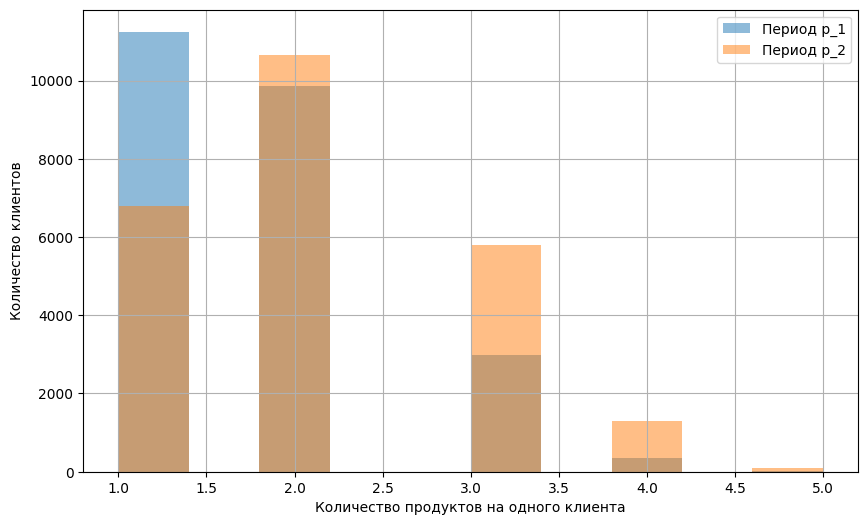

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))

df1.products_p1.hist(bins=10, alpha=0.5, label='Период p_1', ax=ax)

df2.products_p2.hist(bins=10, alpha=0.5, label='Период p_2', ax=ax)

ax.set_xlabel('Количество продуктов на одного клиента')
ax.set_ylabel('Количество клиентов')

ax.legend()

plt.show()